In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LeakyReLU 
import os
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

In [2]:
from numpy.random import seed
seed(1)

# Data

In [3]:
# Number training data samples
N = 10000000

data_1 = np.random.normal(5, 1.2, size=6000000)
data_2 = np.random.normal(10, 1.5, size=4000000)

data = shuffle(np.concatenate((data_1, data_2)))

In [4]:
bins = np.linspace(0, 15, num=16 )
bin_indices = np.digitize(data, bins) - 1

In [5]:
data_temp = ((np.arange(16) == bin_indices[:,None]).astype(int))

(array([9.000000e+01, 2.466000e+03, 3.449600e+04, 2.488360e+05,
        9.280750e+05, 1.787724e+06, 1.800637e+06, 1.002382e+06,
        5.229410e+05, 6.800890e+05, 9.927920e+05, 9.898130e+05,
        6.450650e+05, 2.741970e+05, 7.484500e+04, 1.555200e+04]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15.]),
 <BarContainer object of 16 artists>)

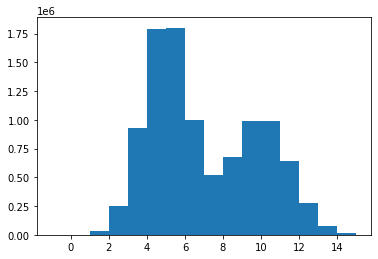

In [6]:
plt.hist(bin_indices, bins = 16)

In [7]:
data_temp

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
np.sum(data_temp[100:200], axis = 0)/100

array([0.  , 0.  , 0.05, 0.09, 0.2 , 0.18, 0.14, 0.05, 0.05, 0.08, 0.1 ,
       0.04, 0.02, 0.  , 0.  , 0.  ])

In [9]:
data_process = []
for i in range(int(N/1000)):
    new_point = np.sum(data_temp[i*1000:(i+1)*1000], axis = 0)/1000
    data_process.append(new_point)
data_processed = np.array(data_process)

In [10]:
BATCH_SIZE = 100
data_loader = DataLoader(data_processed, batch_size=BATCH_SIZE, shuffle=True)

# Networks

## Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(16,)))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation=tf.nn.sigmoid))

    return model

## Generator

In [12]:
n_qubits = 4
# size = 100
q_depth = 3

In [13]:
dev = qml.device("default.qubit", wires= n_qubits)

In [14]:
@qml.qnode(dev, interface="tf")
def qnode(inputs, weights):
    #qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    #qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits),rotation= qml.RY)
    
    # Init distribution
    for a in range(n_qubits):
        qml.Hadamard(wires=a)
    
    # Actual distribution
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RX(weights[3*(i*n_qubits + j)], wires=j)
            qml.RY(weights[3*(i*n_qubits + j) + 1], wires=j)
            qml.RZ(weights[3*(i*n_qubits + j) + 2], wires=j)
            if (j == (n_qubits - 1)):
                qml.CNOT(wires=[j,0])
            else:
                qml.CNOT(wires=[j,j+1])
    
    for k in range(n_qubits):
        qml.RX(weights[(3*q_depth * n_qubits) + k], wires=k)
        qml.RY(weights[(3*q_depth * n_qubits) + k + 1], wires=k)
        qml.RZ(weights[(3*q_depth * n_qubits) + k + 2], wires=k)
    
    
    return qml.probs(wires=range(n_qubits))

In [15]:
weight_shapes = {"weights": (3*(q_depth +1) * n_qubits, 1)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=16)

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(qlayer)

    return model

In [17]:
generator = make_generator_model()


In [18]:
discriminator = make_discriminator_model()

In [19]:
noise = tf.random.normal([100, 4])

In [20]:
generator(noise)

<tf.Tensor: shape=(100, 16), dtype=float64, numpy=
array([[0.02838195, 0.11188212, 0.03544556, ..., 0.01872127, 0.01154338,
        0.06864253],
       [0.02838195, 0.11188212, 0.03544556, ..., 0.01872127, 0.01154338,
        0.06864253],
       [0.02838195, 0.11188212, 0.03544556, ..., 0.01872127, 0.01154338,
        0.06864253],
       ...,
       [0.02838195, 0.11188212, 0.03544556, ..., 0.01872127, 0.01154338,
        0.06864253],
       [0.02838195, 0.11188212, 0.03544556, ..., 0.01872127, 0.01154338,
        0.06864253],
       [0.02838195, 0.11188212, 0.03544556, ..., 0.01872127, 0.01154338,
        0.06864253]])>

# Cost function

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
#generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)

# Training

In [25]:
EPOCHS = 70
noise_dim = n_qubits
num_examples_to_generate = 100
#BUFFER_SIZE = 60000


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        test_data = generator(seed, training=False).numpy()
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        y = range(16)
        ax.bar(y, test_data[0] )
        plt.show()
        
        for n_batch, batch in enumerate(dataset):
            X_batch = tf.convert_to_tensor(batch.numpy())
            train_step(X_batch)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,epochs, seed)

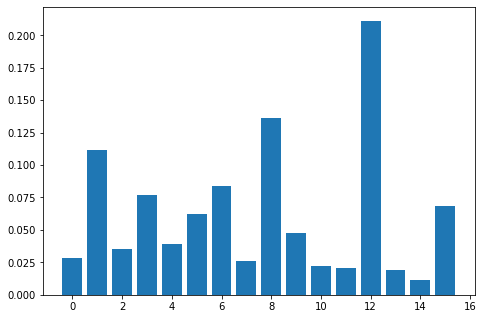

Time for epoch 1 is 1293.6537210941315 sec


Time for epoch 2 is 16.86522102355957 sec


Time for epoch 3 is 16.027530193328857 sec


Time for epoch 4 is 15.502829551696777 sec


Time for epoch 5 is 16.484253406524658 sec


Time for epoch 6 is 16.035839557647705 sec


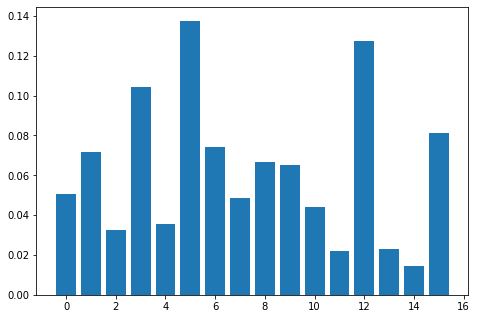

Time for epoch 7 is 15.491565227508545 sec


Time for epoch 8 is 16.416986227035522 sec


Time for epoch 9 is 16.08738422393799 sec


Time for epoch 10 is 15.323793888092041 sec


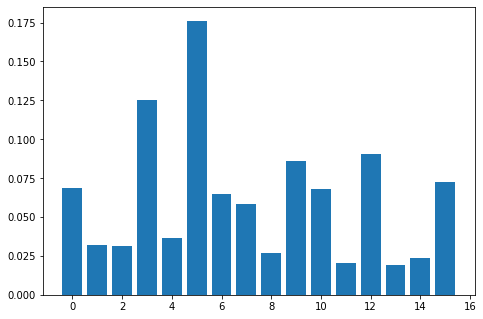

Time for epoch 11 is 16.372642993927002 sec


Time for epoch 12 is 16.4130437374115 sec


Time for epoch 13 is 15.436145067214966 sec


Time for epoch 14 is 16.196057081222534 sec


Time for epoch 15 is 16.63947296142578 sec


Time for epoch 16 is 15.436771869659424 sec


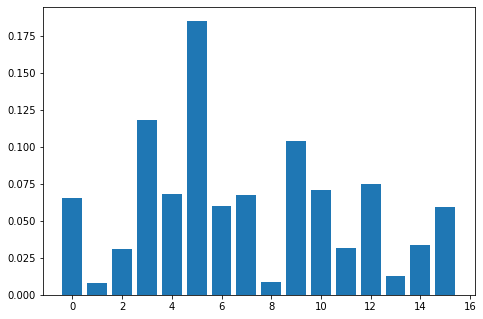

Time for epoch 17 is 16.047098636627197 sec


Time for epoch 18 is 16.509422779083252 sec


Time for epoch 19 is 15.488014936447144 sec


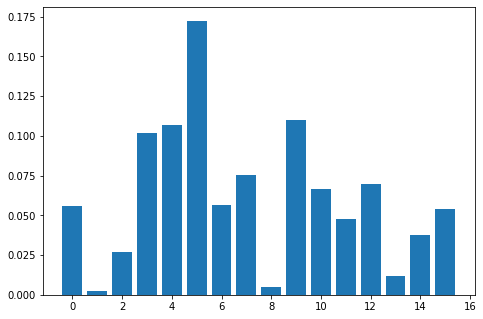

Time for epoch 20 is 15.920194149017334 sec


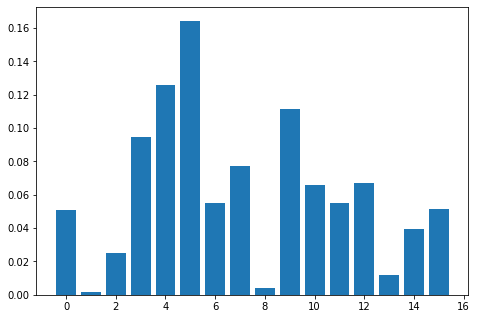

Time for epoch 21 is 16.575603723526 sec


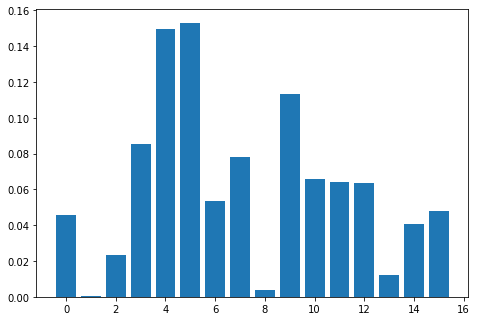

Time for epoch 22 is 15.56189751625061 sec


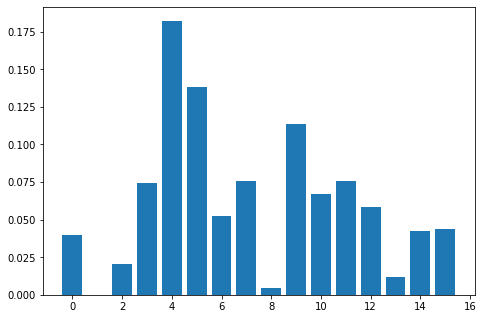

Time for epoch 23 is 15.641802310943604 sec


Time for epoch 24 is 16.433904886245728 sec


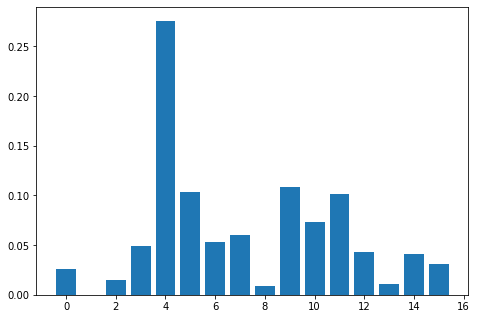

Time for epoch 25 is 16.049232721328735 sec


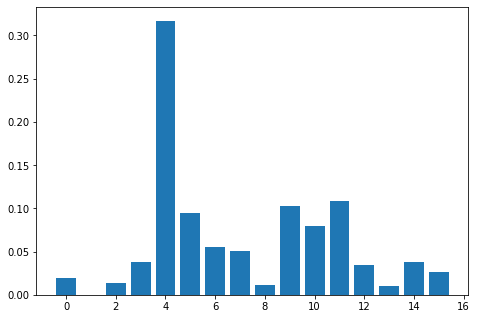

Time for epoch 26 is 17.128124713897705 sec


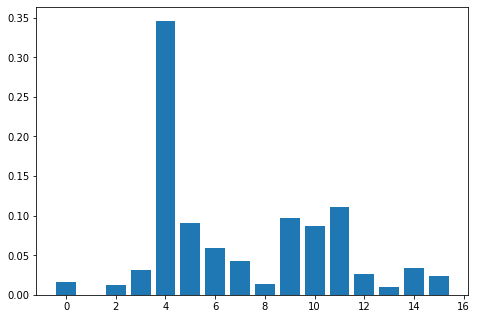

Time for epoch 27 is 18.998284339904785 sec


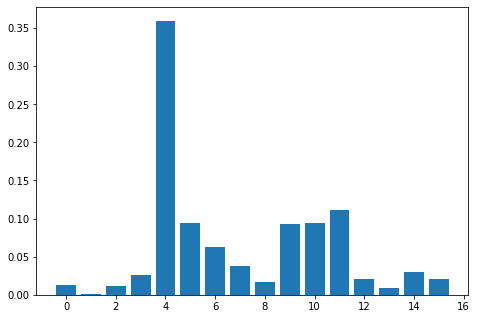

Time for epoch 28 is 17.83492374420166 sec


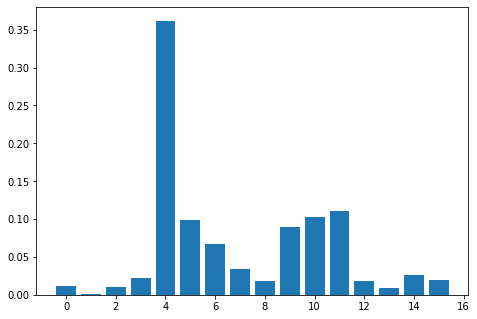

Time for epoch 29 is 16.746493339538574 sec


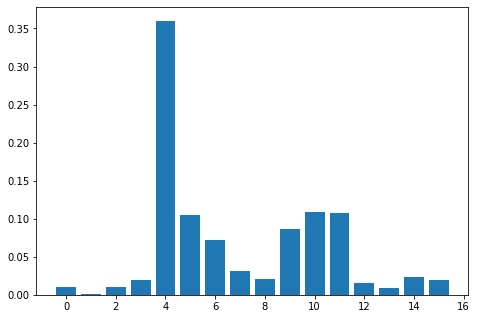

Time for epoch 30 is 16.17751455307007 sec


Time for epoch 31 is 16.54938554763794 sec


Time for epoch 32 is 15.7477867603302 sec


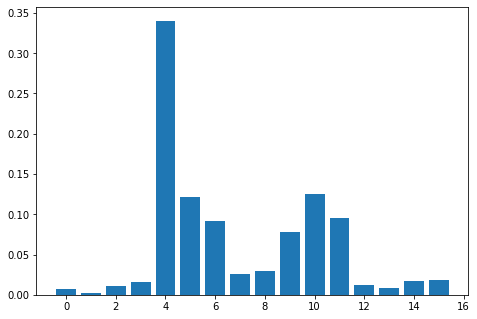

Time for epoch 33 is 16.0143141746521 sec


Time for epoch 34 is 16.47801423072815 sec


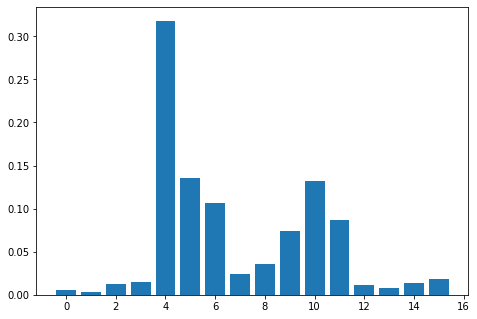

Time for epoch 35 is 17.049031019210815 sec


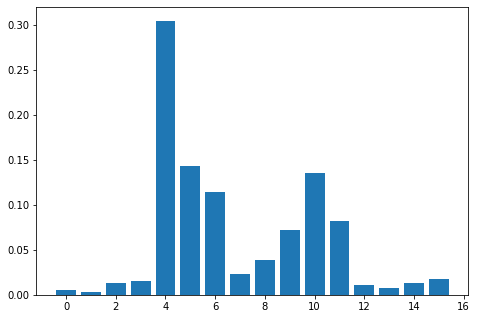

Time for epoch 36 is 15.985696077346802 sec


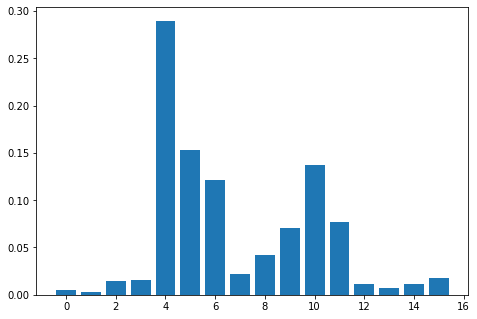

Time for epoch 37 is 16.34157395362854 sec


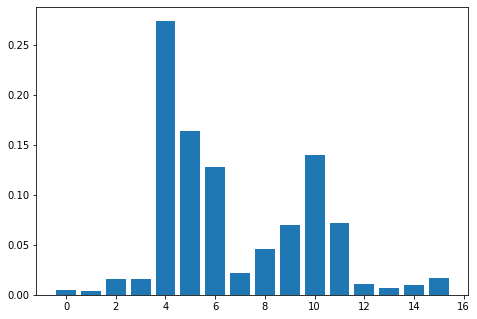

Time for epoch 38 is 16.371017932891846 sec


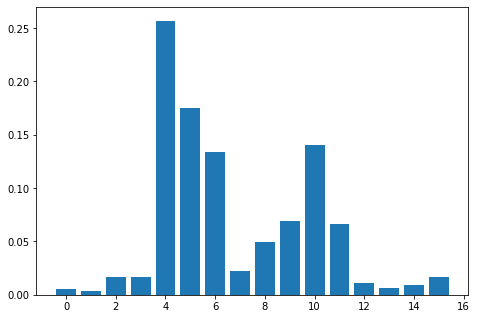

Time for epoch 39 is 16.08224630355835 sec


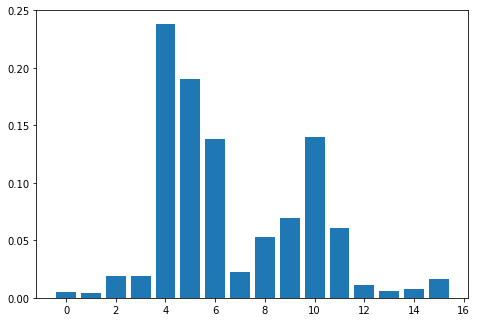

Time for epoch 40 is 16.3663272857666 sec


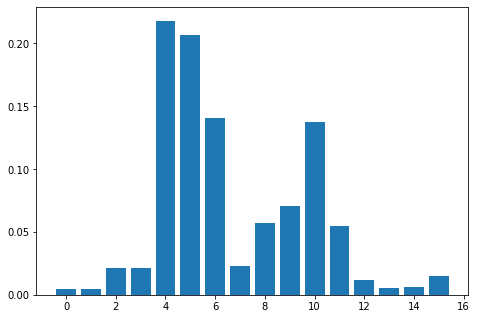

Time for epoch 41 is 16.29935312271118 sec


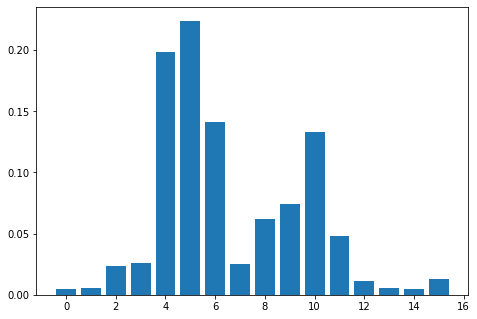

Time for epoch 42 is 15.405291557312012 sec


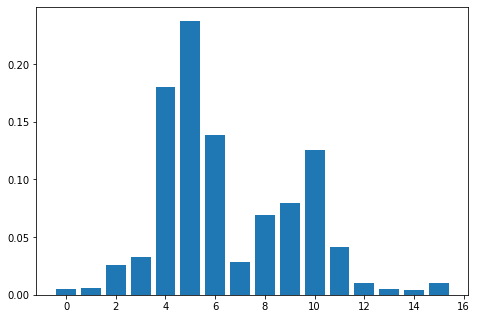

Time for epoch 43 is 16.117807388305664 sec


Time for epoch 44 is 16.46269202232361 sec


Time for epoch 45 is 15.633974075317383 sec


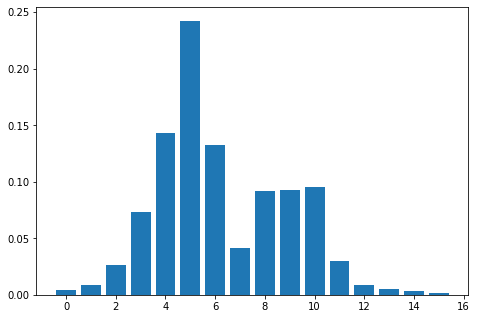

Time for epoch 46 is 15.90065598487854 sec


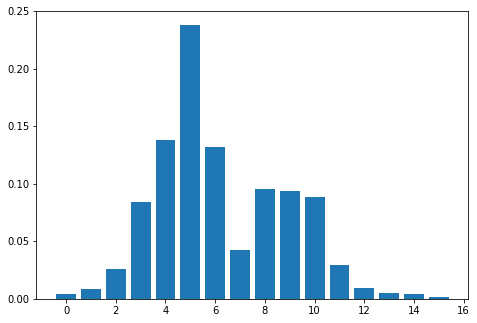

Time for epoch 47 is 16.500058889389038 sec


Time for epoch 48 is 15.954209327697754 sec


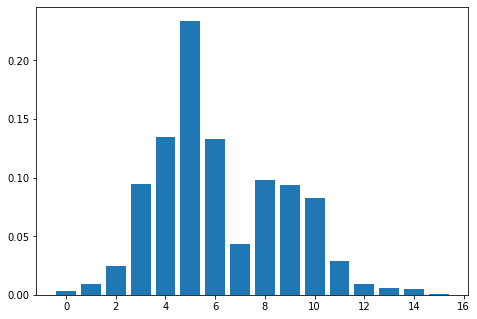

Time for epoch 49 is 14.99990177154541 sec


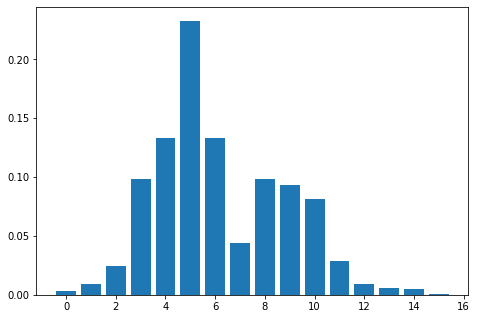

Time for epoch 50 is 12.512274742126465 sec


Time for epoch 51 is 12.526608228683472 sec


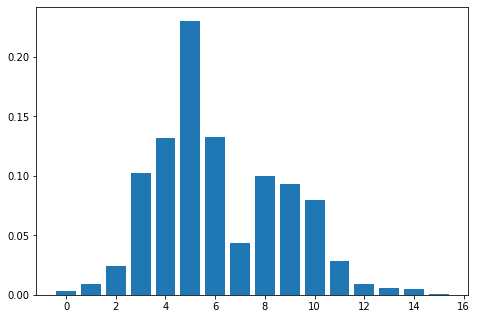

Time for epoch 52 is 12.404088735580444 sec


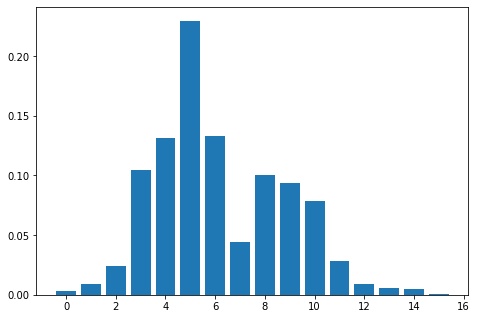

Time for epoch 53 is 13.065150499343872 sec


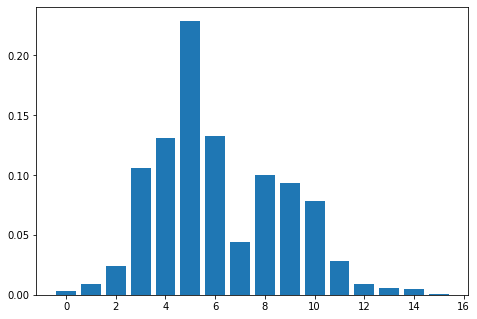

Time for epoch 54 is 13.01794147491455 sec


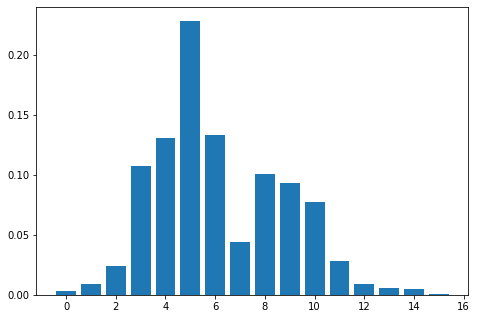

Time for epoch 55 is 13.529083251953125 sec


Time for epoch 56 is 13.045166969299316 sec


Time for epoch 57 is 13.032963275909424 sec


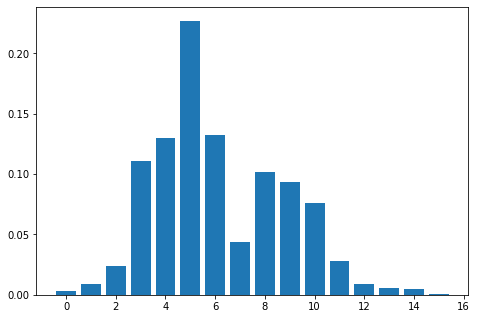

Time for epoch 58 is 13.030632734298706 sec


Time for epoch 59 is 12.569018125534058 sec


Time for epoch 60 is 12.495790719985962 sec


Time for epoch 61 is 12.506361484527588 sec


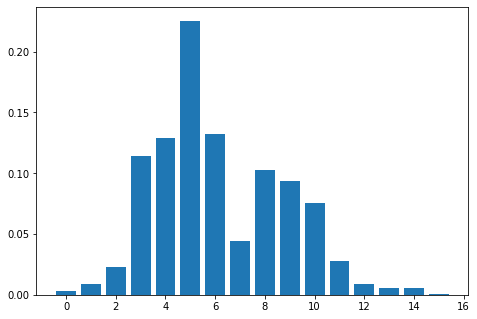

Time for epoch 62 is 12.421476364135742 sec


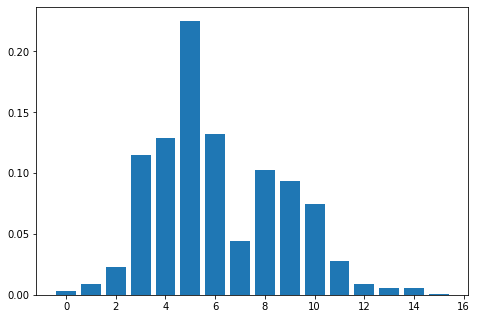

Time for epoch 63 is 12.647292375564575 sec


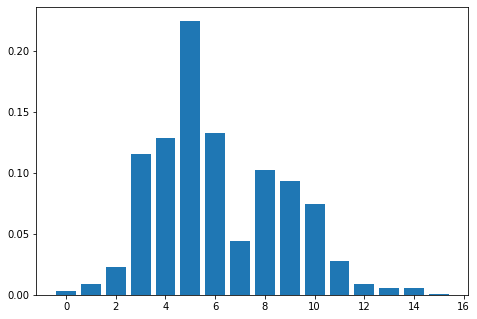

Time for epoch 64 is 12.507572412490845 sec


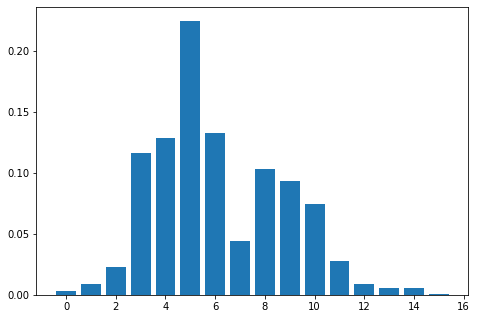

Time for epoch 65 is 12.54722547531128 sec


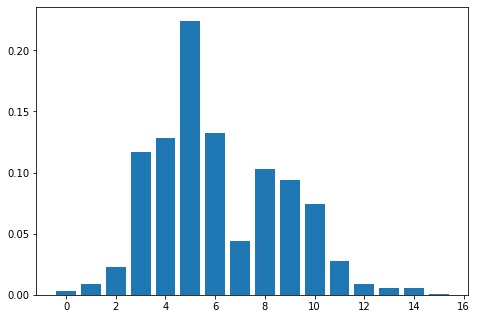

Time for epoch 66 is 12.522351026535034 sec


Time for epoch 67 is 12.540406465530396 sec


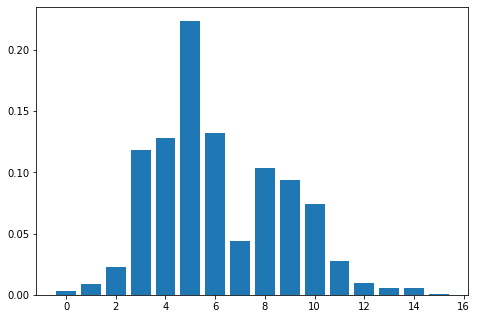

Time for epoch 68 is 12.627902030944824 sec


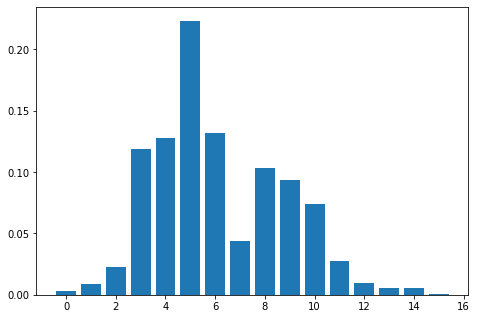

Time for epoch 69 is 12.608609199523926 sec


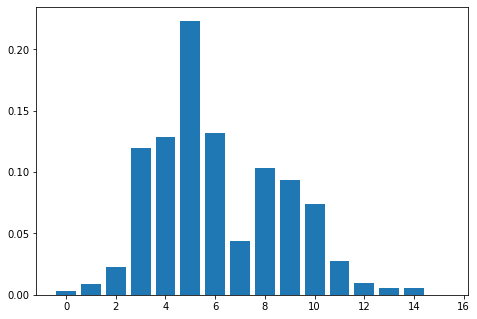

Time for epoch 70 is 12.510106325149536 sec


In [28]:
train(data_loader, EPOCHS)

In [29]:
noise = tf.random.normal([1, 4])
generated_data = generator(noise, training=False).numpy()
generated_data

array([[0.00306729, 0.00842057, 0.02276216, 0.11967397, 0.12797301,
        0.22306437, 0.13204684, 0.04414976, 0.10360613, 0.09368883,
        0.07346458, 0.02781547, 0.00922859, 0.00546486, 0.00533389,
        0.00023969]])

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = range(16)
ax.bar(y, generated_data[0], alpha=0.5)
ax.bar(y, new_point, alpha=0.5)
plt.show()

In [31]:
generator.weights

[<tf.Variable 'sequential/keras_layer/weights:0' shape=(48, 1) dtype=float32, numpy=
 array([[ 0.17507425],
        [-0.719841  ],
        [ 0.91153336],
        [ 0.24424061],
        [-0.1380582 ],
        [ 0.50332475],
        [ 0.11201036],
        [-0.1624932 ],
        [ 0.7130532 ],
        [ 0.32118353],
        [ 0.05413914],
        [-0.92739767],
        [ 0.09096502],
        [-0.14958218],
        [ 0.22202751],
        [ 0.02704864],
        [ 0.11733445],
        [ 0.44617382],
        [ 0.30652574],
        [ 0.6436696 ],
        [-0.17641759],
        [ 0.06278317],
        [-0.20356101],
        [ 0.6011882 ],
        [-0.04598012],
        [-0.00284809],
        [ 0.4022929 ],
        [ 0.4600936 ],
        [ 0.49352545],
        [ 0.6927989 ],
        [ 0.4465154 ],
        [ 0.06298681],
        [-0.9576256 ],
        [-0.9698304 ],
        [-0.02762343],
        [-0.05299457],
        [ 0.57893723],
        [-0.7073255 ],
        [ 0.11229648],
        [ 0.569818